In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor

from sklearn.metrics import mean_absolute_error

import category_encoders as ce

import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
path = Path('../data/interim')

In [44]:
df = pd.read_csv(path / 'properties_post_feature_selection_V2.csv')

In [45]:
df.shape

(5821, 13)

In [46]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,store room,pooja room,furnishing_type,luxury_category,floor_category
0,flat,gota,0.90,3,3,1,Relatively New,1005.0,1,0,unfurnished,High,Mid Floor
1,house,south bopal,6.40,5,5,2,Relatively New,3988.0,0,0,semifurnished,Low,Low Floor
2,flat,gota,0.62,2,2,1,Relatively New,1046.0,1,0,unfurnished,Medium,Low Floor
3,flat,memnagar,0.85,3,3,1,Old Property,1360.0,1,0,semifurnished,Low,Mid Floor
4,house,south bopal,2.30,3,3,1,Moderately Old,2412.0,1,0,unfurnished,Low,Low Floor


In [47]:
df['price'].mean()

1.4500635629616907

In [48]:
# one hot encode -> sector, balcony, agePossession, furnishing type, luxury category, floor category

In [49]:
X = df.drop(columns=['price'])
y = df['price']

In [50]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

In [51]:
df.columns

Index(['property_type', 'sector', 'price', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'store room', 'pooja room',
       'furnishing_type', 'luxury_category', 'floor_category'],
      dtype='object')

In [52]:
columns_to_encode = ['property_type','balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']
numerical_columns = ['bedRoom', 'bathroom', 'built_up_area', 'pooja room', 'store room']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'pooja room', 'store room']),
        ('cat', OrdinalEncoder(), ['property_type','balcony', 'furnishing_type', 'luxury_category', 'floor_category']),
        ('sector', OneHotEncoder(drop='first'), ['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

In [53]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ExtraTreesRegressor())
])

In [54]:
def my_cross_val_score(model,X,Y, cv , label = ''):

    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    #train_predictions = np.zeros((len(train)))
    train_scores, val_scores = [], []

    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, Y)):

        #define train set
        X_train = X.iloc[train_idx]
        y_train = Y.iloc[train_idx]

        #define validation set
        X_val = X.iloc[val_idx]
        y_val = Y.iloc[val_idx]

        #train model
        model.fit(X_train, y_train)

        #make predictions
        train_preds = pipeline.predict(X_train)
        val_preds = pipeline.predict(X_val)
        
        train_preds = np.expm1(train_preds)
        val_preds = np.expm1(val_preds)
        val_predictions[val_idx] += val_preds

        #evaluate model for a fold
        train_score = mean_absolute_error(np.expm1(y_train),train_preds)
        val_score = mean_absolute_error(np.expm1(y_val),val_preds)
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)

    print(f'Val MAE: {np.mean(val_scores):.2f} ± {np.std(val_scores):.2f} | Train MAE: {np.mean(train_scores):.2f} ± {np.std(train_scores):.2f} | {label}')

    return val_scores, train_scores ,val_predictions

In [55]:
models = [
#     ('rf', RandomForestRegressor(min_samples_split=10)),
#     ('svr',SVR(kernel='rbf')),
#     ('lr',LinearRegression()),
#     ('dt',DecisionTreeRegressor()),
#     ('ex',ExtraTreesRegressor()),
#     ('gb',GradientBoostingRegressor()),
#     ('ada',AdaBoostRegressor()),
    ('ridge',Ridge()),
    ('lasso',Lasso(alpha=0.1))
]

In [56]:
test_mae_list, train_mae_list,val_predictions = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [57]:
for model in models:
    pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model[1])
    ])
    test_mae_list[model[0]], train_mae_list[model[0]],_ = my_cross_val_score(
         pipeline, X, y_transformed, cv=kfold,
         label = model[0],

    )

C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_c

C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_c

Val MAE: 0.38 ± 0.03 | Train MAE: 0.37 ± 0.00 | ridge


C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:28: FutureWarning: is

Val MAE: 0.55 ± 0.02 | Train MAE: 0.55 ± 0.00 | lasso


C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is

In [58]:
test_mae_list

,ridge,lasso
0,0.351891,0.553877
1,0.341581,0.544761
2,0.345877,0.511959
3,0.389305,0.538843
4,0.376959,0.556702
5,0.370260,0.541452
6,0.394178,0.547358
7,0.437886,0.588659


C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


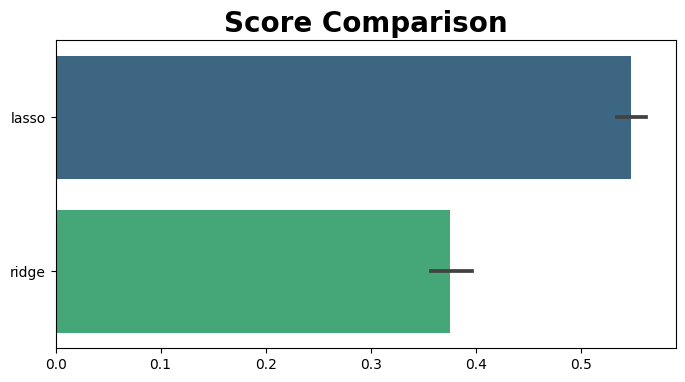

In [59]:
plt.figure(figsize = (8, 4), dpi = 100)
sns.barplot(data = test_mae_list.reindex((-1*test_mae_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 20)
plt.show()

In [60]:
# K-fold cross-validation
kfold = KFold(n_splits=8, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

# test_mae_list['rf'], train_mae_list['rf'],val_predictions['rf'] = my_cross_val_score(pipeline, X, y_transformed, cv=kfold)

C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_c

C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_c

In [61]:
scores.mean()

0.7560580263196741

In [62]:
scores.std()

0.018389692373952465

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [64]:
# model = XGBRegressor().fit(X_train,y_train)
# y_pred = model.predict(X_test)

In [65]:
pipeline.fit(X_train,y_train)

C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_c

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'pooja room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'balcony',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('sector',
                                                  OneHotEncoder(drop='first'),
                                                  ['agePossession']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor', Lasso(alpha=0.1))])

In [66]:
y_pred = pipeline.predict(X_test)

C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)


In [67]:
y_pred

array([0.80692389, 0.67945729, 0.67317765, ..., 0.46736946, 1.24258741,
       0.9527479 ])

In [68]:
y_pred = np.expm1(y_pred)

In [69]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.5561854199122435

In [70]:
input_data = {
    'property_type': 'flat',
    'sector': 'gota',
    'bedRoom': 3,
    'bathroom': 2,
    'balcony': '1',
    'agePossession': 'Relatively New',
    'built_up_area': 1500,
    'store room': 1,
    'pooja room': 1,
    'furnishing_type': 'unfurnished',
    'luxury_category': 'High',
    'floor_category': 'High Floor'
}

input_df = pd.DataFrame([input_data])
predicted_value = pipeline.predict(input_df)

# Print the predicted value
print("Predicted Value:", predicted_value)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''